In [1]:
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout, TimeDistributed, BatchNormalization, Flatten, Activation
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
import numpy as np
import h5py
import matplotlib.pyplot as plt
from data_utils import get_data
from sklearn import preprocessing
from functools import reduce
from scipy.fftpack import dct, idct
from scipy import signal


The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.


Using TensorFlow backend.


In [2]:
# Load data from all .mat files, combine them, eliminate EOG signals, shuffle and 
# seperate training data, validation data and testing data.
# Also do mean subtraction on x.

data = get_data('project_datasets',num_validation=0, num_test=100, subtract_mean=False, subtract_axis=1,
                transpose=True)
for k in data.keys():
    print('{}: {} '.format(k, data[k].shape))

X_train: (2458, 1000, 22) 
y_train: (2458,) 
X_val: (0, 1000, 22) 
y_val: (0,) 
X_test: (100, 1000, 22) 
y_test: (100,) 


In [3]:
# substract data from list
X_train = data.get('X_train')
y_train = data.get('y_train')
#X_val = data.get('X_val')
#y_val = data.get('y_val')
X_test = data.get('X_test')
y_test = data.get('y_test')

# get data dimension
N_train, T_train, C_train = data.get('X_train').shape
N_val, T_val, C_val = data.get('X_val').shape
N_test, T_test, C_test = data.get('X_test').shape

# add dummy zeros for y classification
lb = preprocessing.LabelBinarizer()
lb.fit([0, 1, 2, 3,])
lb.classes_
y_train = lb.transform(y_train)
if (N_val > 0): y_val = lb.transform(y_val)
y_test = lb.transform(y_test)

In [4]:
# Filtering through FFT(discrete cosine transform)

def filter(x, low=0, high=1, plot=False):
    N = x.shape[0]
    t = np.linspace(0,N,N)
    y = dct(x, norm='ortho')
    window = np.zeros(N)
    window[int(low*N):int(high*N)] = 1
    yr = idct(y*window, norm='ortho')
    sum(abs(x-yr)**2) / sum(abs(x)**2)
    if plot:
        plt.plot(t, x, '-b')
        plt.plot(t, yr, 'r')
    return x

# Filter band
low_freq = 0.02
high_freq = 0.4

for i in np.arange(N_train):
    for j in np.arange(C_train):
       X_train[i,:,j]= filter(X_train[i,:,j],low_freq,high_freq)
for i in np.arange(N_val):
    for j in arange(C_val):
       X_val[i,:,j]= filter(X_val[i,:,j],low_freq,high_freq)
    
for i in np.arange(N_test):
    for j in np.arange(C_test):
       X_test[i,:,j]= filter(X_test[i,:,j],low_freq,high_freq)


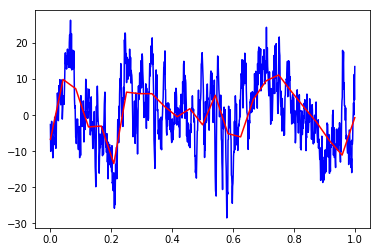

In [5]:
# Downsampling in time through FFT

t_sample = 25
X_train_sub = signal.resample(X_train,t_sample,axis=1)
if (N_val > 0): X_val_sub = signal.resample(X_val,t_sample,axis=1)
X_test_sub = signal.resample(X_test,t_sample,axis=1)

# show a downsampling example
plt.plot(np.linspace(0,1,T_train),X_train[5,:,5],'-b')
plt.plot(np.linspace(0,1,t_sample),X_train_sub[5,:,5],'-r')

In [6]:
print(X_train_sub.shape)

(2458, 25, 22)


In [7]:
# # normalize data across the time sequence dimension only
# scaler = preprocessing.MinMaxScaler()
# for i in range(N_train):
#     scaler.fit(X_train[i,:,:])
#     X_train[i,:,:] = scaler.transform(X_train[i,:,:])
    
# for i in range(N_val):
#     scaler.fit(X_val[i,:,:])
#     X_val[i,:,:] = scaler.transform(X_val[i,:,:])

In [8]:
# def downsample(data, mul=10, enableTrunc = False):
#     assert data.shape[0] % mul == 0 or  enableTrunc, "Can't downsample without data truncation.\
#                                                 \n Set another value of mul or set enableTrunc = True"
#     outdata = []
#     for i in range(data.shape[0]//mul):
#         outdata.append(np.mean(data[i*mul:(i+1)*mul,...], axis=0, keepdims=True))
#     outdata = reduce(lambda a,b: np.append(a,b,0), outdata)
    
#     return outdata
# span = 2
# X_train_sub = np.expand_dims(downsample(X_train[0,:,:], mul=span),axis=0)
# for n in np.arange(1,X_train.shape[0]):
#     X_train_sub = np.append(X_train_sub,
#                             np.expand_dims(downsample(X_train[n,:,:], mul=span),axis=0),axis=0)

# X_val_sub = np.expand_dims(downsample(X_val[0,:,:], mul=span),axis=0)
# for n in np.arange(1,X_val.shape[0]):
#     X_val_sub = np.append(X_val_sub,
#                             np.expand_dims(downsample(X_val[n,:,:], mul=span),axis=0),axis=0)

# print('X_train_sub: ', X_train_sub.shape)
# print('X_val_sub: ', X_val_sub.shape)

In [9]:
# Expected input shape: ([batch_size], timesteps, data_dim)
# Note that we have to provide the full batch_input_shape if the network is stateful.
# the sample of index i in batch k is the follow-up for the sample i in batch k-1.

# perhaps should try masking layer

data_dim = C_train
seq_split = 1 # Set to one when using FFT to down sample
seq_len = int(X_train_sub.shape[1]*seq_split)
timesteps = seq_len
num_classes = 4
batch_size = 200
num_epoch = 150

model = Sequential()
#1
model.add(LSTM(200, return_sequences=True, stateful=False,
          recurrent_dropout=0.5, dropout = 0.5, input_shape=(timesteps, data_dim)))

#2
model.add(LSTM(100, return_sequences=True, stateful=False,
          recurrent_dropout=0.5, dropout = 0.5))

#3
model.add(LSTM(50, return_sequences=True, stateful=False,
          recurrent_dropout=0.5, dropout = 0.5))
model.add(Flatten())

#4
model.add(Dense(100))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(Dropout(0.5))

#5
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# define early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=70, mode='auto')

# saves the model weights after each epoch if the validation loss decreased
checkpointer = ModelCheckpoint(filepath='LSTM_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True)

callbacks_list = [earlystop, checkpointer]

In [10]:
history = model.fit(X_train_sub[:,:seq_len,:], y_train,
                    batch_size=batch_size, epochs=num_epoch, shuffle=True,
                    validation_split = 0.15, callbacks=callbacks_list)

Train on 2089 samples, validate on 369 samples
Epoch 1/150
2089/2089 [==============================] - 8s 4ms/step - loss: 1.8359 - acc: 0.2513 - val_loss: 1.3883 - val_acc: 0.3117

Epoch 00001: val_acc improved from -inf to 0.31165, saving model to LSTM_model.hdf5
Epoch 2/150
2089/2089 [==============================] - 4s 2ms/step - loss: 1.7422 - acc: 0.2542 - val_loss: 1.3820 - val_acc: 0.3252

Epoch 00002: val_acc improved from 0.31165 to 0.32520, saving model to LSTM_model.hdf5
Epoch 3/150
2089/2089 [==============================] - 5s 2ms/step - loss: 1.6862 - acc: 0.2599 - val_loss: 1.3738 - val_acc: 0.3252

Epoch 00003: val_acc did not improve
Epoch 4/150
2089/2089 [==============================] - 7s 3ms/step - loss: 1.6471 - acc: 0.2743 - val_loss: 1.4272 - val_acc: 0.3333

Epoch 00004: val_acc improved from 0.32520 to 0.33333, saving model to LSTM_model.hdf5
Epoch 5/150
2089/2089 [==============================] - 5s 3ms/step - loss: 1.5741 - acc: 0.2863 - val_loss: 1.33

2089/2089 [==============================] - 4s 2ms/step - loss: 1.2676 - acc: 0.4241 - val_loss: 1.2361 - val_acc: 0.4472

Epoch 00042: val_acc did not improve
Epoch 43/150
2089/2089 [==============================] - 4s 2ms/step - loss: 1.2522 - acc: 0.4327 - val_loss: 1.2455 - val_acc: 0.4580

Epoch 00043: val_acc improved from 0.45799 to 0.45799, saving model to LSTM_model.hdf5
Epoch 44/150
2089/2089 [==============================] - 4s 2ms/step - loss: 1.2560 - acc: 0.4351 - val_loss: 1.2630 - val_acc: 0.4228

Epoch 00044: val_acc did not improve
Epoch 45/150
2089/2089 [==============================] - 4s 2ms/step - loss: 1.2470 - acc: 0.4184 - val_loss: 1.2302 - val_acc: 0.4526

Epoch 00045: val_acc did not improve
Epoch 46/150
2089/2089 [==============================] - 4s 2ms/step - loss: 1.2452 - acc: 0.4538 - val_loss: 1.2290 - val_acc: 0.4444

Epoch 00046: val_acc did not improve
Epoch 47/150
2089/2089 [==============================] - 4s 2ms/step - loss: 1.2496 - acc: 0

2089/2089 [==============================] - 2s 758us/step - loss: 1.1118 - acc: 0.5160 - val_loss: 1.1992 - val_acc: 0.4851

Epoch 00086: val_acc did not improve
Epoch 87/150
2089/2089 [==============================] - 2s 839us/step - loss: 1.1206 - acc: 0.5194 - val_loss: 1.2171 - val_acc: 0.5122

Epoch 00087: val_acc improved from 0.50136 to 0.51220, saving model to LSTM_model.hdf5
Epoch 88/150
2089/2089 [==============================] - 2s 897us/step - loss: 1.1206 - acc: 0.5108 - val_loss: 1.2053 - val_acc: 0.4905

Epoch 00088: val_acc did not improve
Epoch 89/150
2089/2089 [==============================] - 2s 1ms/step - loss: 1.1228 - acc: 0.5270 - val_loss: 1.2088 - val_acc: 0.4986

Epoch 00089: val_acc did not improve
Epoch 90/150
2089/2089 [==============================] - 2s 1ms/step - loss: 1.1081 - acc: 0.5314 - val_loss: 1.2082 - val_acc: 0.5068

Epoch 00090: val_acc did not improve
Epoch 91/150
2089/2089 [==============================] - 2s 1ms/step - loss: 1.0999 - 

2089/2089 [==============================] - 2s 844us/step - loss: 0.9817 - acc: 0.5792 - val_loss: 1.2689 - val_acc: 0.4824

Epoch 00132: val_acc did not improve
Epoch 133/150
2089/2089 [==============================] - 2s 842us/step - loss: 0.9898 - acc: 0.5840 - val_loss: 1.2594 - val_acc: 0.4824

Epoch 00133: val_acc did not improve
Epoch 134/150
2089/2089 [==============================] - 2s 844us/step - loss: 0.9707 - acc: 0.5993 - val_loss: 1.2880 - val_acc: 0.4851

Epoch 00134: val_acc did not improve
Epoch 135/150
2089/2089 [==============================] - 2s 836us/step - loss: 0.9575 - acc: 0.6075 - val_loss: 1.2647 - val_acc: 0.4824

Epoch 00135: val_acc did not improve
Epoch 136/150
2089/2089 [==============================] - 2s 814us/step - loss: 0.9668 - acc: 0.6017 - val_loss: 1.2921 - val_acc: 0.4607

Epoch 00136: val_acc did not improve
Epoch 137/150
2089/2089 [==============================] - 2s 753us/step - loss: 0.9540 - acc: 0.6094 - val_loss: 1.3003 - val_ac

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


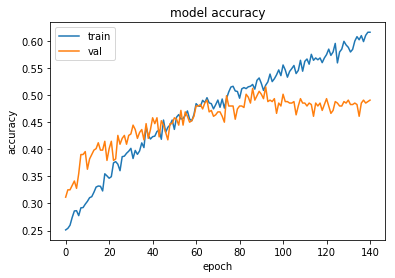

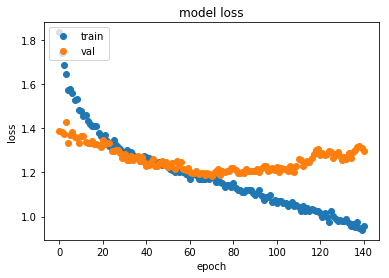

In [11]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'],'o')
plt.plot(history.history['val_loss'],'o')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [14]:
# evaluate model on entire training set
model = load_model('LSTM_model.hdf5')
model.evaluate(X_train_sub,y_train,batch_size=N_train)


2458/2458 [==============================] - 1s 557us/step


[0.94229727983474731, 0.62205046415328979]

In [15]:
# evaluate model on test set
model.evaluate(X_test_sub,y_test,batch_size=N_test)

100/100 [==============================] - 0s 397us/step


[1.2040615081787109, 0.47999998927116394]